In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf

import glob
import sys
import os
from collections import OrderedDict

import csv

sys.path.insert(0, "../casa/")
from plot_utils import *
from genome_utils import *

# General Setup
This is a small analysis of _ERP29_, a gene in the _ATXN_ locus.

Collecting files here.

In [2]:
EPR1_fn = '../data/ERP29_rep1detailed.txt'
ERR2_fn = '../data/ERP29_rep2detailed.txt'

fn_list = [EPR1_fn,ERR2_fn]

exp_ids = ['EPR1','EPR2']

fullinfo= [("ERP29",1), ("ERP29",2)]

id2info = { exp_id: info for exp_id, info in zip(exp_ids, fullinfo) }

id2info['k27'] = ('H3K27ac', 1)
id2info['DHS'] = ('DHS', 1)

In [3]:
# Peak BED files
# MAINTAIN ORDER (see exp_ids variable above)
EPR1_bed= '../data/ERP29_rep1__highORpeaks.bed'
EPR2_bed= '../data/ERP29_rep2__highORpeaks.bed'

exp_beds= [EPR1_bed, EPR2_bed]

K27_bed = '../data/k27ac_replicatePeaks_hg38_scoreFiltered.bed'
DHS_bed = '../data/DNASE_peaks_replicated.bed'

extra_beds = [ K27_bed, DHS_bed ]
extra_tags = [ 'k27', 'DHS' ]

# Load and preprocess data

In [4]:
gff = pd.read_table('../data/ATXN_locus.gff')

/home/sagergosai/miniconda3/envs/casa/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


In [5]:
gff

,name,chrom,strand,txStart,txEnd,cdsStart,cdsEnd,exonCount,exonStarts,exonEnds,proteinID,transcriptID,geneID
0,ENST00000335007.10,chr12,-,110719679,110742891,110721075,110742707,7,"110719679,110722134,110722471,110724659,110730...","110721165,110722269,110722695,110724764,110730...",P36873,uc001tru.5,PPP1CC
1,ENST00000545036.5,chr12,+,110846959,110907534,110853515,110907476,11,"110846959,110853404,110858585,110873841,110879...","110847105,110853574,110858775,110873961,110880...",Q8NA47,uc010sye.3,CCDC63
2,ENST00000228841.13,chr12,-,110910818,110920600,110911076,110920529,7,"110910818,110913095,110913245,110914185,110915...","110911175,110913144,110913324,110914290,110915...",Q6IB42,uc001try.6,MYL2
3,ENST00000261726.11,chr12,+,111034164,111350554,111034177,111348325,22,"111034164,111214199,111217889,111263760,111291...","111034240,111214310,111217937,111263839,111291...",O14529,uc001tsa.5,CUX2
4,ENST00000361483.4,chr12,-,111360650,111369121,111362677,111365566,4,"111360650,111365563,111366112,111368911","111363463,111365651,111366257,111369121",Q8N4B1,uc021rdy.1,PHETA1
5,ENST00000377617.8,chr12,-,111452267,111599676,111452811,111599514,25,"111452267,111453676,111456028,111457213,111464...","111452840,111453845,111456256,111457359,111464...",Q99700,uc001tsj.4,ATXN2
6,ENST00000419234.9,chr12,-,111642145,111685956,111644198,111685792,12,"111642145,111649938,111655565,111658735,111659...","111644562,111650042,111655655,111658845,111659...",Q7Z569,uc001tsn.5,BRAP
7,ENST00000455480.6,chr12,+,111686075,111757094,111692709,111756473,22,"111686075,111692696,111702161,111705737,111709...","111686239,111692896,111702310,111705932,111709...",Q6JQN1,uc009zvx.4,ACAD10
8,ENST00000261733.7,chr12,+,111766932,111817532,111766982,111809575,13,"111766932,111781917,111783157,111785266,111789...","111767096,111782022,111783298,111785346,111789...",P05091,uc001tst.5,ALDH2
9,ENST00000551404.6,chr12,+,111842625,111893161,111842733,111893061,14,"111842625,111865249,111866155,111867571,111868...","111842769,111865323,111866231,111867669,111868...",Q8IW41,uc001tta.5,MAPKAPK5


In [6]:
data = []
for i, fn in enumerate(fn_list):
    d_pt = pd.read_table(fn,sep='\t',header=0)
    ## Rescale to floats
    rescale = min(d_pt['LS_reads'].sum(),d_pt['HS_reads'].sum()) / d_pt.loc[:,('HS_reads','LS_reads')].sum(axis=0)
    d_pt.loc[:,('HS_reads','LS_reads')] *= rescale
    ## Sample downsized library
    runif              = np.random.uniform(size=d_pt.loc[:,('HS_reads','LS_reads')].shape)
    int_part, sample_p = np.divmod( d_pt.loc[:,('HS_reads','LS_reads')], 1 )
    d_pt.loc[:,('HS_reads','LS_reads')] = int_part + (runif < sample_p)
    ## Return as int
    d_pt.loc[:,('HS_reads','LS_reads')] = d_pt.loc[:,('HS_reads','LS_reads')].astype(int) + 1
    d_pt[exp_ids[i]] = np.log( d_pt['LS_reads'] / d_pt['HS_reads'] )
    data.append( d_pt.loc[((~d_pt['Coordinates'].str.contains("CTRL")) &\
                           (~d_pt['Coordinates'].str.contains("NT")) &\
                           (~d_pt['Coordinates'].str.contains('FILLER-LV2')) &\
                           (~d_pt['Coordinates'].str.contains('FILLER-SgO'))),
                          ('Coordinates',exp_ids[i])] )

/home/sagergosai/miniconda3/envs/casa/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
data = pd.concat([ df.set_index('Coordinates') for df in data ],axis=1)

In [8]:
data['cutsite'] = [ int(coord.split(':')[1].split('-')[1]) - 4 
                      if coord.split(':')[-1] == '+' 
                      else 
                    int(coord.split(':')[1].split('-')[0]) + 3 
                      for coord in data.index ]

In [9]:
# Get experimental peaks
## Read in files
test_peaks = [ pd.read_table(
                 fn,sep='\t',header=None,
                 names=['chr','start','end','hdr','pass','strand']
               ) 
               for fn in exp_beds ]
## Figure out which chromosomes were tested
tested_chr = pd.concat( test_peaks, axis=0 )['chr'].unique()
## Filter out non-significant peaks
test_peaks = [ merge_bed(
                   df.loc[ df['pass'] == True, ('chr','start','end') ].copy()
               )
               for df in test_peaks ]
## Filter out tiny peaks
test_peaks = [ df[ (df['end'] - df['start']) > 100 ]
               for df in test_peaks ]

print("Experimental track count: {}".format(len(test_peaks)))

# Add on extra features from ENCODE
## Read in files
extra_feat = [ pd.read_table(fn,sep='\t',header=None,
                             names=['chr','start','end'],usecols=[0,1,2]) 
               for fn in extra_beds ]
## Filter out un-tested chromosomes for speed
chr_filters = [ np.vstack([feat['chr'] == chrom for chrom in tested_chr ]).any(axis=0) 
                for feat in extra_feat ]

# Combine
[ test_peaks.append( feat.loc[ chr_filter ,:] ) for feat, chr_filter in zip(extra_feat, chr_filters) ]
test_peaks = [ df.reset_index(drop=True) for df in test_peaks ]
print("Total track count: {}".format(len(test_peaks)))
for exp_id, peaks_idx in zip(exp_ids+extra_tags,range(len(test_peaks))):
    test_peaks[peaks_idx]['exp_id'] = exp_id
    test_peaks[peaks_idx]['assay'] = id2info[exp_id][0]
    test_peaks[peaks_idx]['replicate'] = id2info[exp_id][1]
    
test_peaks = pd.concat(test_peaks,axis=0,ignore_index=True)


Experimental track count: 2
Total track count: 4


/home/sagergosai/miniconda3/envs/casa/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: read_table is deprecated, use read_csv instead.
  import sys
/home/sagergosai/miniconda3/envs/casa/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: read_table is deprecated, use read_csv instead.


# Plot guide-wise scores with peaks
Lines indicate min-max interval between all replicates.

ERP29
38


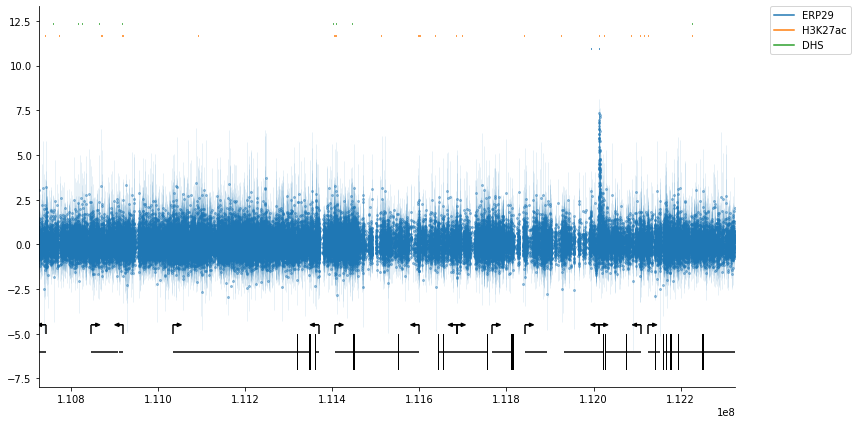

In [10]:
fig_h, ax_h = plot_combined_cutsites(np.array([[110726026,112325903]]), 
          data, test_peaks, plot_ids=['EPR1','EPR2','k27','DHS'])
draw_genes_from_gff(ax_h, gff, promoter_params=[10000,0.2,10000])
fig_h.savefig('plots/ATXN_locus__110726026_112325903__ERP29_only.pdf')

ERP29
1


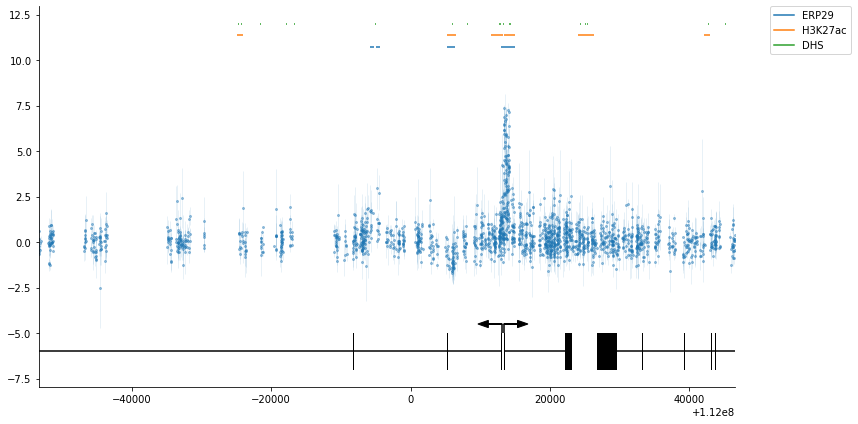

In [11]:
fig_h, ax_h = plot_combined_cutsites(np.array([[111946626,112046626]]), 
          data, test_peaks, plot_ids=['EPR1','EPR2','k27','DHS'])
draw_genes_from_gff(ax_h, gff, promoter_params=[2000,0.4,1500])
fig_h.savefig('plots/ATXN_locus__111946626_112046626__ERP29_only.pdf')

ERP29
0


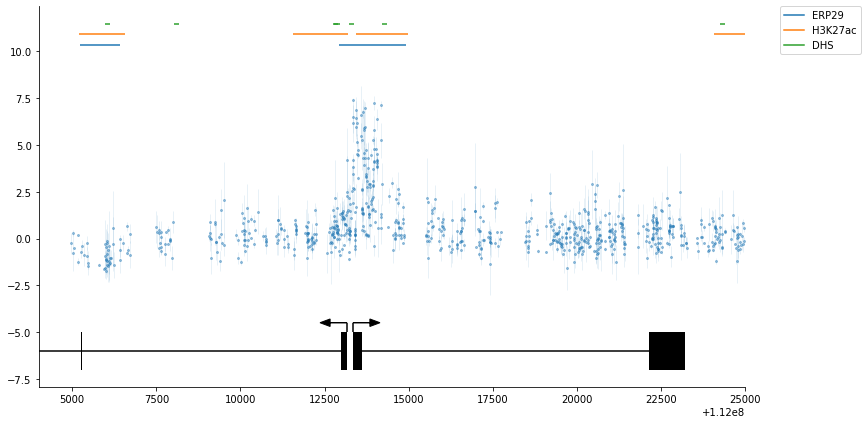

In [12]:
fig_h, ax_h = plot_combined_cutsites(np.array([[112004000,112025000]]), 
          data, test_peaks, plot_ids=['EPR1','EPR2','k27','DHS'])
draw_genes_from_gff(ax_h, gff, promoter_params=[500,0.4,300])
fig_h.savefig('plots/ATXN_locus__112004000_112025000__ERP29_only.pdf')

# Connection diagram
Summarize CRE promoter interactions

In [13]:
txn_starts = extract_txn_starts(gff)

pack_TSSs   = [('ERP29',txn_starts['ERP29'][0],txn_starts['ERP29'][1])]

In [14]:
txn_starts

{'PPP1CC': ('chr12', 110742891),
 'CCDC63': ('chr12', 110846959),
 'MYL2': ('chr12', 110920600),
 'CUX2': ('chr12', 111034164),
 'PHETA1': ('chr12', 111369121),
 'ATXN2': ('chr12', 111599676),
 'BRAP': ('chr12', 111685956),
 'ACAD10': ('chr12', 111686075),
 'ALDH2': ('chr12', 111766932),
 'MAPKAPK5': ('chr12', 111842625),
 'TMEM116': ('chr12', 112013165),
 'ERP29': ('chr12', 112013347),
 'NAA25': ('chr12', 112108783),
 'TRAFD1': ('chr12', 112125544),
 'HECTD4': ('chr12', 112382092),
 'SH2B3': ('chr12', 111405947)}

In [15]:
ERP29_only_peaks = filter_by_guide_coverage(
    get_replicating_peaks( test_peaks[(test_peaks['assay'] == 'ERP29')] ), 
    pd.read_table(EPR1_fn,sep='\t',header=0)['Coordinates'], min_coverage=1
)

pack_peaks       = [ERP29_only_peaks]

all_locus_peaks = pd.concat(pack_peaks).reset_index(drop=True)

/home/sagergosai/miniconda3/envs/casa/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
all_locus_peaks

,chr,start,end,guide_coverage
0,chr12,111994126,111994726,10
1,chr12,111995026,111995626,11
2,chr12,112005226,112006426,38
3,chr12,112012926,112014926,199


In [17]:
ERP29_total_scores = get_peak_strengths(EPR1_bed, EPR2_bed)

pack_scores = [ERP29_total_scores]


../casa/plot_utils.py:312: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  for fn in argv ]


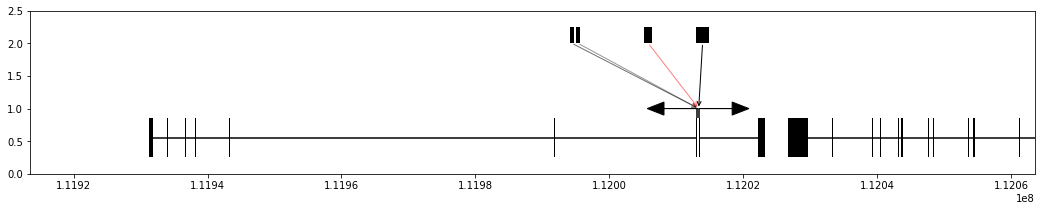

In [18]:
fig = plt.figure(figsize=(18,3))
ax  = plt.subplot(111)
glims = [111913514,112063514]
ax.set_xlim( *glims )
ax.set_ylim(0.0, 2.5)
draw_genes_from_gff(ax, gff, promoter_params=[5000,0.2,2500], gene_ylim=[0.25,1.0])
draw_bed_blocks(ax, all_locus_peaks, ylims=[2.0,2.25])
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['ERP29'], y_anchor=2.0, y_target=1.0, score_bed=ERP29_total_scores, xlims=glims)

plt.savefig('plots/ERP29_locus__111913514_112063514__connectogram.pdf')

plt.show()

In [19]:
write_bed_format([ x.iloc[:,0:3] for x in pack_peaks ], pack_scores, pack_TSSs, 
                 '../data/ERP29__replicating_peaks__{}.bed'.format('highOR'))